# Redes Neuronales

## Preliminares

### 1. Funciones de costo

Recordemos que una función lineal tiene la forma $y = mx + b$, donde $m$ es la pendiente y $b$ es la ordenada al origen.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os #esta libreria permite trabajar con funciones del sistema operativo 
import random

In [2]:
x = np.linspace(-1,1,100)
m_0 = 2 # el verdadero valor de la pendiente
b_0 = -3 # el verdadero valor de la ordenada al origen
y = m_0*x + b_0 + 0.25*np.random.randn(x.size) #agregamos ruido

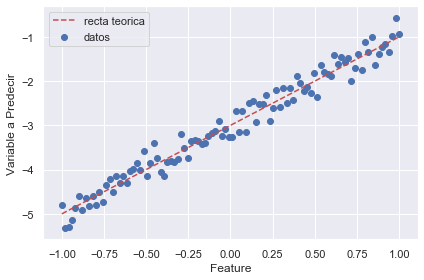

In [3]:
plt.scatter(x,y, label = 'datos')
plt.plot(x, m_0*x + b_0, '--', c = 'r', label = 'recta teorica')
plt.ylabel('Variable a Predecir')
plt.xlabel('Feature')
plt.legend()
plt.tight_layout()
if False:
    plt.savefig('Datos_ajuste_.png', dpi= 400)
plt.show()

En general, uno tiene ciertos datos y de esos datos quiere estimar los valores del modelo, en este caso, la pendiente y ordenada al origen de la recta. La hipótesis que vamos a utilizar es que la recta que mejor aproxime los datos va a ser la recta teórica que "genera" los datos.

Pero para definir la recta que "mejor aproxime" tenemos que cuantificar que es, precisamente, aproximar bien. Para ello usamos una métrica. En este caso vamos a usar MSE.

In [4]:
def MSE(y,y_pred):
    '''Calcula Mean Squared Error'''
    assert(len(y) == len(y_pred))
    n = len(y)
    return ((y - y_pred)**2).sum()/n

# def RMSE(y,y_pred):
#     '''Calcula Root Mean Squared Error'''
#     assert(len(y) == len(y_pred))
#     cost = MSE(y,y_pred)
#     return np.sqrt(cost)

# def MAE(y,y_pred):
#     '''Calcula Mean Absolut Error'''
#     assert(len(y) == len(y_pred))
#     n = len(y)
#     return (np.abs(y - y_pred)).sum()/n

#### **Un parametro libre**

Supongamos que conocemos la ordenada al origen $b$, y solamente tenemos que obtener la pendiente $m$. Lo que podemos hacer entonces es *barrer* distintos valores para $m$ y ver a cuál corresponde el mínimo del costo. **Importante**: en este caso, la función de costo depende de un único parámetro, $m$.

In [5]:
%%time
m_s = np.linspace(-5,5,1000)
b = -3
costos = []
for m in m_s:
    y_pred = m*x + b
    costos.append(MSE(y,y_pred))

costos = np.array(costos)

Wall time: 12.3 ms


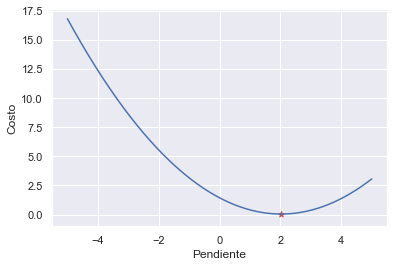

In [6]:
indice_minimo = np.argmin(costos)

plt.plot(m_s, costos)
plt.scatter(m_s[indice_minimo], costos[indice_minimo], marker = '*', c = 'r')
plt.xlabel('Pendiente')
plt.ylabel('Costo')
plt.show()

#### **Dos parámetros libres**

Antes de continuar, piensen qué modificarían en el caso de tener que encontrar no uno sino dos parámetros libres. Es decir, $m$ y $b$. En este caso, ¿de cuántos parámetros depende la función de costo?¿Cómo será su visualización?

In [7]:
m_s = np.linspace(-5,5,500)
b_s = np.linspace(-5,0,500)

In [8]:
%%time
costos = []
for m in m_s:
    for b in b_s:
        y_pred = m*x + b
        costos.append(MSE(y,y_pred))
costos = np.array(costos)

Wall time: 4.09 s


**Visualización**

In [9]:
Ms, Bs = np.meshgrid(m_s,b_s, indexing = 'ij')
costos_matriz = costos.reshape(m_s.size, b_s.size)

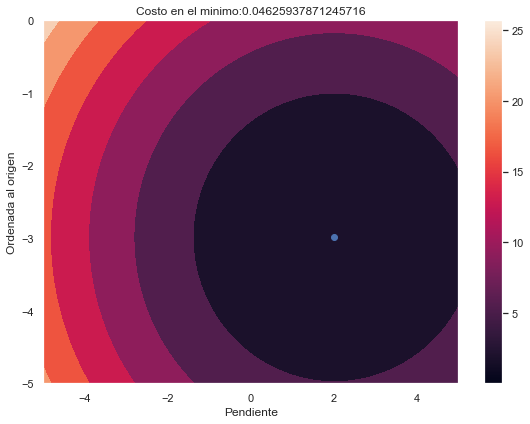

In [10]:
idxs_minimo = np.unravel_index(costos_matriz.argmin(), costos_matriz.shape)
fig = plt.figure(figsize = (8,6))
ax = fig.gca()

plt.pcolormesh(Ms, Bs,costos_matriz)
ax.contourf(Ms, Bs, costos_matriz)
plt.colorbar()
plt.scatter(Ms[idxs_minimo], Bs[idxs_minimo])
plt.title('Costo en el minimo:' + str(costos_matriz[idxs_minimo]))
plt.xlabel('Pendiente')
plt.ylabel('Ordenada al origen')
plt.tight_layout()
plt.show()

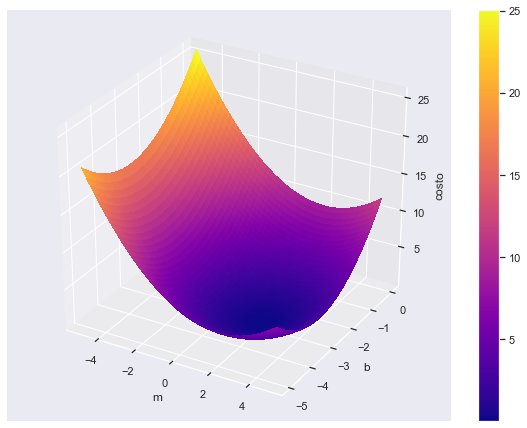

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

fig = plt.figure(figsize = (8,6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(Ms, Bs,costos_matriz,linewidth=0.0, antialiased=False, cmap = 'plasma')
# ax.view_init(0, 180)
ax.set_xlabel('m')
ax.set_ylabel('b')
ax.set_zlabel('costo')
plt.tight_layout()
plt.colorbar(surf)    
# plt.savefig('costo_3d.png', dpi = 400)
plt.show()

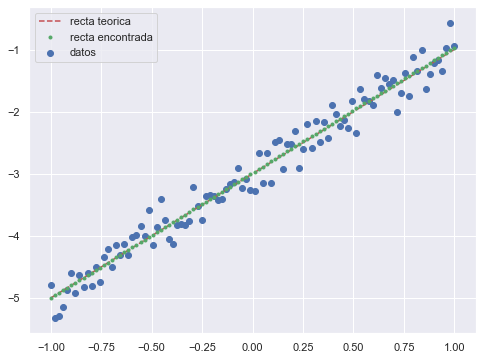

In [12]:
m_encontrado = Ms[idxs_minimo]
b_encontrado = Bs[idxs_minimo]

plt.figure(figsize = (8,6))
plt.scatter(x,y, label = 'datos')
plt.plot(x, m_0*x + b_0, '--', c = 'r', label = 'recta teorica')
plt.plot(x, m_encontrado*x +b_encontrado, '.', c = 'g', label = 'recta encontrada')
plt.legend()
plt.show()

### 2. Descenso por gradiente

**Nota**: Para los que nunca hayan visto análisis matemático, no importa si no entienden lo que sigue. La idea que les tiene que quedar es que podemos obtener la dirección en la cual movernos para llegar al mínimo de la función de costo.


Para hacer descenso por gradiente necesitamos las derivadas. Notar que la función de costo es función de la pendiente $m$ y la ordenada al origen $b$. Para simplificar, vamos a asumir que después de hacer varios reemplazos y algunas cuentas, la función de costo tiene la siguiente forma:

$$MSE(m, b) = (m-2)^2 + (b+3)^2$$

¿Están de acuerdo que el mínimo se obtiene para $m = 2$ y $b = -3$? Si no están de acuerdo, discutir con el compañero hasta que lo estén.

Escribimos la función MSE, sus derivadas y el gradiente.


In [13]:
def MSE_m_y_b(m,b):
    return (m-2)**2 + (b+3)**2

def der_MSE_m(m,b):
    '''Derivada de MSE respecto a m'''
    return 2*(m-2)

def der_MSE_b(m,b):
    '''Derivada de MSE respecto a b'''
    return 2*(b+3)

def gradiente(m,b):
    gradiente = np.array([der_MSE_m(m,b), der_MSE_b(m,b)])
    return gradiente

Elegimos un valor para $m$ y otro para $b$ y calculamos el gradiente.

In [14]:
m_prueba = -2 #Solo aca tienen que cambiar
b_prueba = -3 #Solo aca tienen que cambiar

grad = gradiente(m_prueba, b_prueba)
print(grad)

### Esto es para que tenga norma 1. Ignorar
grad = grad/np.linalg.norm(grad)
print(grad)

[-8  0]
[-1.  0.]


Y ahora graficamos la función de costo con menos el gradiente obtenido para el punto elegido.

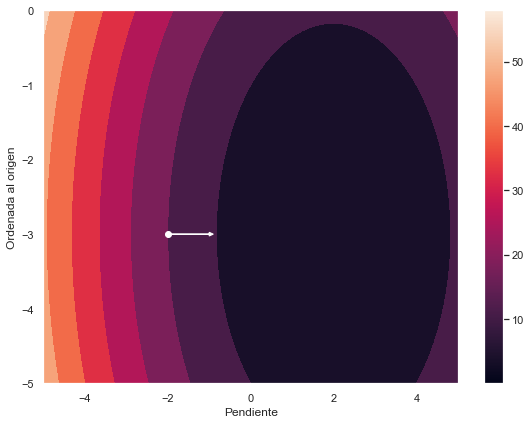

In [15]:
fig = plt.figure(figsize = (8,6))
ax = fig.gca()

plt.pcolormesh(Ms, Bs,MSE_m_y_b(Ms, Bs))
ax.contourf(Ms, Bs, MSE_m_y_b(Ms, Bs))
plt.colorbar()

plt.scatter(m_prueba,b_prueba, c="white")
plt.arrow(m_prueba,b_prueba, -grad[0], -grad[1], head_width=0.05, head_length=0.1, fc='white', ec='white')

plt.xlabel('Pendiente')
plt.ylabel('Ordenada al origen')
plt.tight_layout()
plt.show()

Modificar los valores de `m_prueba` y `b_prueba` y convercerse de que el negativo del gradiente apunta hacia el mínimo. **Importante**: ¿Cuánto vale el gradiente en el mínimo?



**Descenso por gradiente**

Descenso por gradiente consiste entonces en ir haciendo sucesivos pasos, siguiendo la dirección que marca el negativo del gradiente, hasta llegar al mínimo o muy cerca de él. En general:

1. Empezamos con valores aleatorios de los parámetros.
2. Repetimos tantas veces como sea necesario
    1. Calculamos el gradiente (derivadas) de la función de costo respecto al valor actual de los parámetros.
    2. Actualizamos los valores de los parámetros siguiendo menos la derivada para cada uno.
    $$ m_{nuevo} = m_{viejo} - \alpha * \frac{dMSE(m,b)}{dm} $$
    $$ b_{nuevo} = b_{viejo} - \alpha * \frac{dMSE(m,b}{db} $$
      
      
Al **hiperparámetro** $\alpha$ se lo conoce como *learning rate* y lo van a encontrar en casi todos los frameworks donde se implemente descenso por gradiente. Es, sin duda, uno de los principales hiperparámetros en cualquier desarrollo con redes neuronales.

Lo implementamos.

In [16]:
m = -1   #por ahora, los elegimos a mano, pero deberia ser al azar
b = -1   #por ahora, los elegimos a mano, pero deberia ser al azar

max_steps = 500 # Modificar despues
alpha = 0.01

In [17]:
costos = []
m_obtenidos = []
b_obtenidos = []

for step in range(max_steps):
    costos.append(MSE_m_y_b(m,b))
    m_obtenidos.append(m)
    b_obtenidos.append(b)
    m = m - alpha*der_MSE_m(m,b)
    b = b - alpha*der_MSE_b(m,b)

# Agregamos el ultimo paso que no lo hicimos
costos.append(MSE_m_y_b(m,b))
m_obtenidos.append(m)
b_obtenidos.append(b)

# Llevamos a arreglos
costos = np.array(costos)
m_obtenidos = np.array(m_obtenidos)
b_obtenidos = np.array(b_obtenidos)

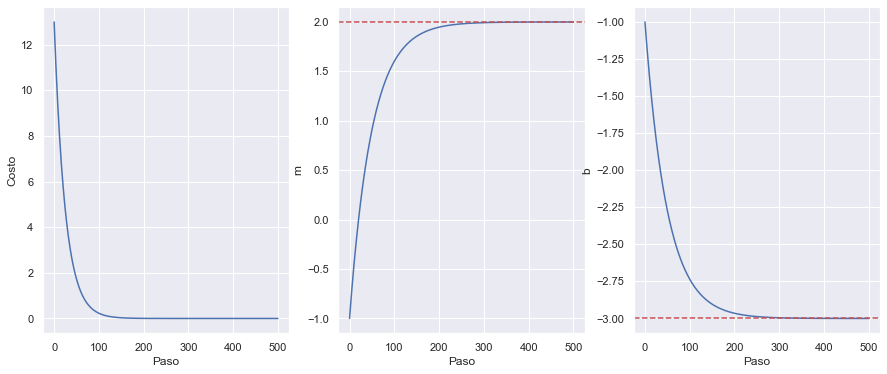

In [18]:
plt.figure(figsize = (15,6))

plt.subplot(1,3,1)
plt.plot(costos)
plt.xlabel('Paso')
plt.ylabel('Costo')

plt.subplot(1,3,2)
plt.plot(m_obtenidos)
plt.axhline(m_0, linestyle = '--', c = 'r', label = 'm real')
plt.xlabel('Paso')
plt.ylabel('m')

plt.subplot(1,3,3)
plt.plot(b_obtenidos)
plt.axhline(b_0,  linestyle = '--', c = 'r', label = 'b real')
plt.xlabel('Paso')
plt.ylabel('b')



plt.show()

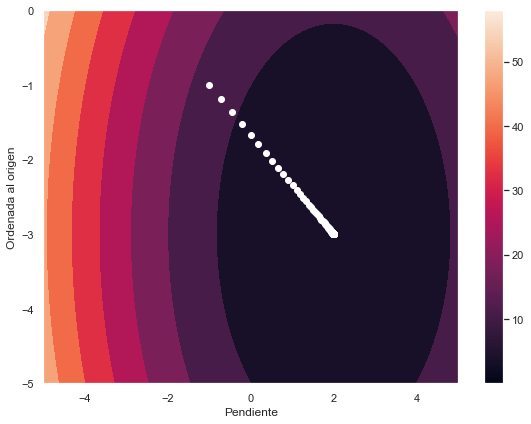

In [19]:
fig = plt.figure(figsize = (8,6))
ax = fig.gca()

plt.pcolormesh(Ms, Bs,MSE_m_y_b(Ms, Bs))
ax.contourf(Ms, Bs, MSE_m_y_b(Ms, Bs))
plt.colorbar()
plt.scatter(m_obtenidos[::5],b_obtenidos[::5], c="white") #notar que grafica cada 5 pasos
plt.xlabel('Pendiente')
plt.ylabel('Ordenada al origen')
plt.tight_layout()
plt.show()

### ¿Anda siempre?

In [20]:
x = np.linspace(-1,1,500)
y = np.sin(10*x)

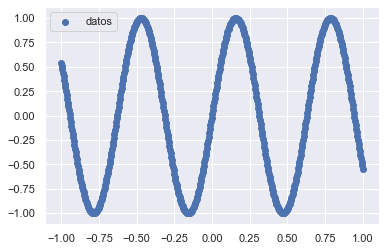

In [21]:
plt.scatter(x,y, label = 'datos')
plt.legend()
plt.show()

In [22]:
w_s = np.linspace(0,50,1000)
costos = []
for w in w_s:
    y_pred = np.sin(w*x)
    costos.append(MSE(y,y_pred))
costos = np.array(costos)

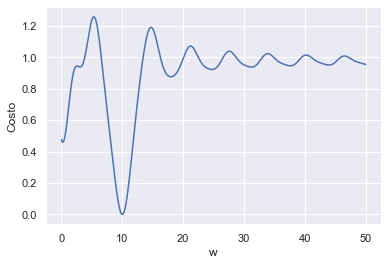

In [23]:
plt.plot(w_s, costos)
plt.xlabel('w')
plt.ylabel('Costo')
plt.show()

Notar que hay muchos *mínimos locales* y un *mínimo absoluto*. En más dimensiones, es fácil confundir un mínimo local con el mínimo que estamos buscando.

**Variantes de descenso por el gradiente (para acelerar/mejorar la convergencia)**:
1. Stochastic gradient descent (SGD)
2. Minibatches
3. Agregar un término para dar inercia a la búsqueda, tratando de pasar por alto mínimos locales.


**Responder**

1. Definir Función de costo
2. Qué es la taza de aprendizaje.
3. Sea f alguna función para que f (θ0, θ1) emite un número. Para este problema f es alguna función suave arbitraria / desconocida (no necesariamente lafunción de costo de una regresión lineal, por lo que f puede tener óptimos locales). Supongamos que usamos la pendiente de gradiente para tratar de minimizar f (θ0, θ1) en función de θ0 y θ1. Cuales de las siguientes afirmaciones son ciertas? (Marque todo lo que corresponda.)

    Incluso si la tasa de aprendizaje α es muy grande, cada iteración del descenso del gradiente disminuirá el valor de f (θ0, θ1).

    Si la tasa de aprendizaje es demasiado pequeña, entonces el descenso del gradiente puede tardar mucho tiempo en converger.

    Si θ0 y θ1 se inicializan en un mínimo local, entonces una iteración no cambiará sus valores.

    Si θ0 y θ1 se inicializan de modo que θ0 = θ1, entonces por simetría (porque hacemos actualizaciones simultáneas a los dos parámetros), después de una iteración de descenso de gradiente, todavía tendremos θ0 = θ1.